In [1]:
import time
from dotenv import load_dotenv

load_dotenv()

import wandb

wandb.login()

if wandb_run := wandb.run:
  wandb_run.finish()

wandb_run = wandb.init(
  project="CommonsenseQA 2.1",
  name=f"model1-{time.strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "batch_size": 4,
    "learning_rate": 1e-6,
    "max_tokens": 128,
  }
)
config = wandb.config

wandb: Currently logged in as: weightsandbiases-doodle198 (weightsandbiases-doodle198-anonymous) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import torch

torch.set_default_dtype(torch.float32)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(DEVICE)

tensor = torch.tensor([2., 3.])
print(tensor.device)
print(tensor.dtype)

cuda:0
torch.float32


In [3]:
import os
import pandas as pd

from torch.utils.data import Dataset
import random

class CommonsenseDataset(Dataset):
  def __init__(self, data_path):
    super().__init__()
    
    if not os.path.exists(data_path):
      raise FileNotFoundError(f"Data file {data_path} does not exist.")
    
    self.data = pd.read_parquet(data_path)
    
    self.data = self.data[["question", "choices.text", "choices.label", "answerKey"]]
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    item = self.data.iloc[idx]
    choices = item["choices.text"]
    labels = item["choices.label"]
    
    if len(labels) == len(choices):
      ziped = list(zip(choices, labels))
      random.shuffle(ziped)
      choices, labels = zip(*ziped)
    
    answer_key = item["answerKey"]

    return {
        "question": item["question"],
        "choices": [choice for choice in choices],
        "labels": [lable == answer_key for lable in labels],
    }

CommonsenseDataset("./commonsense_qa/data/validation.parquet")[3]

{'question': 'Where are  you likely to find a hamburger?',
 'choices': ['pizza',
  'mouth',
  'fast food restaurant',
  'ground up dead cows',
  'cow carcus'],
 'labels': [False, False, True, False, False]}

In [4]:
from torch.utils.data import DataLoader

class CommonsenseDataLoader(DataLoader):
  def __init__(self, dataset, **kwargs):
    super().__init__(
      dataset,
      generator=torch.Generator(device=DEVICE),
      collate_fn=lambda x: {key: [item[key] for item in x] for key in x[0].keys()},
      **kwargs,
    )

In [5]:
dataset = CommonsenseDataset("./commonsense_qa/data/validation.parquet")
loader = CommonsenseDataLoader(
  dataset, 
  batch_size=config.batch_size, 
  shuffle=True,
)

In [6]:
from typing import List
from torch.nn import Module, Linear
import torch.nn.functional as F
import re

NUM_CHOICES = 5

class Model(Module):
    def __init__(self, tokenizer, base_model):
        super(Model, self).__init__()
        
        self.tokenizer = tokenizer
        self.base_model = base_model
        
        hidden_dim = base_model.config.hidden_size
        
        self.classifier = Linear(hidden_dim, 1)
        

    def forward(self, batched_question: List[str], batched_choices: List[List[str]]):
        assert len(batched_question) == len(batched_choices)
        
        input = self.tokenizer(
            [question for question in batched_question for _ in range(NUM_CHOICES)],
            [choice for choices in batched_choices for choice in choices],
            truncation=True,
            padding="max_length",
            max_length=config.max_tokens,
            return_tensors="pt",
        )
        
        hidden_states = self.base_model(input["input_ids"], input["attention_mask"]).last_hidden_state
        last_token_hidden_state = hidden_states[:, -1, :]
        
        logits = self.classifier(last_token_hidden_state)
        
        logits = logits.view(-1, NUM_CHOICES)
        
        logits = F.softmax(logits, dim=-1)
        
        return logits
    
    def text_preprocess(self, text: str):
        text = text.lower()
        
        text = re.sub(r"[\t\n\r]", " ", text)
        text = re.sub(r" {2,}", " ", text)
        
        return text.strip()
        

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base", use_fast=False)
base_model = AutoModel.from_pretrained("microsoft/deberta-v3-base").to(DEVICE)

In [8]:
def load_model(model, path):
    if not path.endswith(".pt"):
        path += ".pt"
    path = os.path.join("./checkpoints", path)
    
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    return model

In [9]:
model = Model(tokenizer, base_model)

In [14]:
model = load_model(model, "model_20250617_180334_17")

In [11]:
validation_loader = CommonsenseDataLoader(
  CommonsenseDataset("./commonsense_qa/data/validation.parquet"), 
  shuffle=True, 
  batch_size=50
)

def validation_accuracy(model):
  batch = next(iter(validation_loader))
  
  question = batch["question"]
  choices = batch["choices"]
  labels = torch.tensor(batch["labels"], dtype=torch.float32)
  
  with torch.no_grad():
    logits = model(question, choices)
    
  predictions = torch.argmax(logits, dim=1)
  
  accuracy = (predictions == torch.argmax(labels, dim=-1)).float().mean()
  
  return accuracy.item()
  
validation_accuracy(model)

0.14000000059604645

In [12]:
import os
import time

def save_model(model, epoch):
  model_dir = "./checkpoints"
  os.makedirs(model_dir, exist_ok=True)
  model_path = os.path.join(model_dir, f"model_{time.strftime('%Y%m%d_%H%M%S')}_{epoch}.pt")
  torch.save(model.state_dict(), model_path)

In [13]:
from torch.optim import AdamW
from torch.nn.functional import cross_entropy

model.train()
optimizer = AdamW(model.parameters(), lr=config.learning_rate)
loss_fn = cross_entropy

try:
    try:
        epoch = epoch
    except NameError:
        epoch = 0
    
    for epoch in range(epoch, 10000):
        print(f"Epoch {epoch}")

        for batch in loader:
            question = batch['question']
            choices = batch['choices']
            labels = batch['labels']
        
            optimizer.zero_grad()
            
            prediction = model(question, choices)
            
            expected = torch.tensor(labels, dtype=torch.float32, device=DEVICE)
            loss = loss_fn(prediction, expected)
            loss.backward()
            optimizer.step()
        
            print(f"Loss: {loss.item()}")
            wandb.log({"loss": loss.item()})
        
        accuracy = validation_accuracy(model)
        wandb.log({"epoch": epoch, "accuracy": accuracy})
        save_model(model, epoch)

except KeyboardInterrupt:
    print("Training interrupted by user.")

Epoch 0
Loss: 1.660219430923462
Loss: 1.6334853172302246
Loss: 1.6242961883544922
Loss: 1.6201173067092896
Loss: 1.6301379203796387
Loss: 1.597752332687378
Loss: 1.6041070222854614
Loss: 1.614606499671936
Loss: 1.6328610181808472
Loss: 1.5854346752166748
Loss: 1.5964112281799316
Loss: 1.6011219024658203
Loss: 1.6240887641906738
Loss: 1.6157697439193726
Loss: 1.6263272762298584
Loss: 1.604760766029358
Loss: 1.5966479778289795
Loss: 1.5926856994628906
Loss: 1.6208724975585938
Loss: 1.5724093914031982
Loss: 1.6137819290161133
Loss: 1.5818268060684204
Loss: 1.6118152141571045
Loss: 1.5781774520874023
Loss: 1.6310060024261475
Loss: 1.548014521598816
Loss: 1.6470777988433838
Loss: 1.6427417993545532
Loss: 1.64324951171875
Loss: 1.5721687078475952
Loss: 1.6152803897857666
Loss: 1.5560177564620972
Loss: 1.5919666290283203
Loss: 1.5673348903656006
Loss: 1.6335314512252808
Loss: 1.611311674118042
Loss: 1.5762666463851929
Loss: 1.5885264873504639
Loss: 1.6286338567733765
Loss: 1.611955165863037
L

In [ ]:
save_model(model, "final1")

In [15]:
wandb_run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▂▂▁▁▂▂▃▆▆▆▆▇▇▇▆▇██▆▇▇▇▇▇
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█████▇▇▇███▇█▆▅▆▆▇▆▄▅▅▅▆▄▆▅▄▆▄▂▄▃▁▃▃▂▅▇▁
accuracy,0.74
epoch,23
loss,0.99406


In [16]:
test_dataset = CommonsenseDataset("./commonsense_qa/data/test.parquet")

with torch.no_grad():
  for i in range(10):
    item = test_dataset[i]
    question = item["question"]
    choices = item["choices"]
    
    prediction = model([question], [choices])
    
    max_index = prediction.argmax(dim=-1).item()
    
    print(question)
    print(choices)
    print(choices[max_index])


The townhouse was a hard sell for the realtor, it was right next to a high rise what?
['suburban development', 'michigan', 'suburbs', 'apartment building', 'bus stop']
apartment building
There is a star at the center of what group of celestial bodies?
['outer space', 'hollywood', 'skyline', 'solar system', 'constellation']
solar system
What were the kids doing as they looked up at the sky and clouds?
['ponder', 'wonder about', 'open door', 'distracting', 'become adults']
ponder
The person taught an advanced class only for who?
['wonderful memories', 'own self', 'own house', 'know truth', 'intelligent children']
intelligent children
What is a likely consequence of ignorance of rules?
['hostility', 'bliss', 'find truth', 'damage', 'accidents']
accidents
After graduating the dentist set up his dental office back where he grew up, he wanted to always live in his home what?
['neighborhood', 'town', 'office building', 'city', 'street']
city
Something that has a long and sharp blade is a?
['c

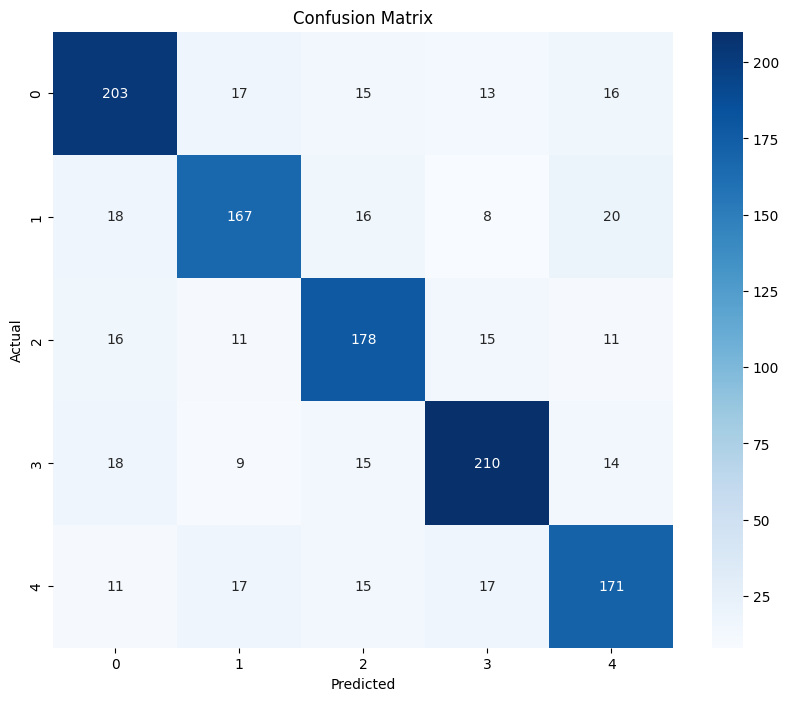

In [17]:
validation_dataset = CommonsenseDataset("./commonsense_qa/data/validation.parquet")
loader = CommonsenseDataLoader(
  validation_dataset, 
  batch_size=4, 
  shuffle=True,
)

predictions = []
expected = []

for b_i, batch in enumerate(loader):
    question = batch['question']
    choices = batch['choices']
    
    with torch.no_grad():
        probabilities = model(question, choices)
    
    batch_predictions = torch.argmax(probabilities, dim=-1).cpu().tolist()
    
    batch_expected = torch.tensor(batch['labels'], dtype=torch.float32, device=DEVICE)
    batch_expected = torch.argmax(batch_expected, dim=-1).cpu().tolist()
    
    predictions.extend(batch_predictions)
    expected.extend(batch_expected)
    
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
pass